# Three investigators - part 4

A project for scraping and analysing data from a fan site on the audio book called '[The three investigators](https://en.wikipedia.org/wiki/Three_Investigators#Germany)'

Part 4: Data cleaning and analysis

- data cleaning and preparing for analysis
- explorative analysis of data
- saving output files for data visualisations in datawrapper

# Setup

In [1]:
#python version used for this project
from platform import python_version
print(python_version())

3.7.5


In [2]:
# import modules [as specified in requirements.txt]
import pandas as pd
import numpy as np
import re
import requests
from datetime import date
import matplotlib.pyplot as plt

# for file directories
import os

%matplotlib inline

In [3]:
#change directory to root folder
os.chdir("..")

# Load data

In [4]:
#load scraped datafiles
meta = pd.read_csv(".\\data\\scraped\\meta.csv")
content = pd.read_csv(".\\data\\scraped\\content.csv")
rating = pd.read_csv(".\\data\\scraped\\ratings.csv")

#load cleaned actors
actors = pd.read_csv(".\\data\\processed\\actors_cleaned_2020-11-23.csv")

#load title analysis
title_cat = pd.read_csv(".\\data\\processed\\title_categories_2020-11-23.csv")

#load actor gender prediction
gender = pd.read_csv(".\\data\\processed\\actor_gender_prediction_2020-11-23.csv")

In [5]:
print("meta:", meta.shape, "actors:" , actors.shape, "content:", content.shape, "rating:", rating.shape)

meta: (206, 33) actors: (2873, 8) content: (207, 2) rating: (239, 6)


# Data cleaning and prep

## Actors

### Remove episode 29 and duplicates

In [6]:
## remove 29 from actors table as it is music only
actors = actors.loc[actors["id"] != 29]

### Remove duplicates from actors table
actors = actors.drop_duplicates()

### Rename roles

In [7]:
#replace values
actors["role"] = actors["role"].str.replace("Mrs ", "Mrs. ").str.replace("Mr ", "Mr. ")
actors.loc[actors["role"].str.contains("Justus Jonas"), "role"] = 'Justus Jonas'
actors.loc[actors["role"].str.contains("ERZÄHLER"), "role"] = 'Erzähler'
actors.loc[actors["role"].str.contains("Peter Shaw"), "role"] = 'Peter Shaw'
actors.loc[actors["role"].str.contains("Bob Andrews"), "role"] = 'Bob Andrews'
actors.loc[actors["role"].str.contains("Hitchcock"), "role"] = 'Hitchcock'
actors.loc[actors["role"].str.contains("Mathilda"), "role"] = 'Tante Mathilda'
actors.loc[actors["role"].str.contains("Titus"), "role"] = 'Onkel Titus'
actors.loc[actors["role"].str.contains("Reynolds"), "role"] = 'Kommissar Reynolds'
actors.loc[actors["role"].str.contains("Skinny"), "role"] = 'Skinny Norris'
actors.loc[actors["role"].str.contains("Godween"), "role"] = 'Goodween'
#actors.loc[actors["role"].str.contains("Mr Shaw"), "role"] = 'Mr. Shaw'
actors.loc[actors["role"].str.contains("Herr Andrews"), "role"] = 'Mr. Andrews'
actors.loc[actors["role"].str.contains("Morton"), "role"] = 'Morton'
actors.loc[actors["role"].str.contains("Inspektor Cottahol"), "role"] = 'Inspektor Cotta'
actors.loc[actors["role"].str.contains("Cotta, Polizeiinspektor"), "role"] = 'Inspektor Cotta'
actors.loc[actors["role"].str.contains("Hugenay"), "role"] = 'Hugenay'
actors.loc[actors["role"].str.contains("Jelena"), "role"] = 'Jelena'

#create filter for main actor
actors["main_actor"] = 0
actors.loc[(actors["role"]=='Justus Jonas') | (actors["role"]=='Peter Shaw') | (actors["role"]=='Bob Andrews'), "main_actor"] = 1

#create filter for narrator
actors["narrator"] = 0
actors.loc[(actors["role"]=='Hitchcock') | (actors["role"]==u'Erzähler'), "narrator"] = 1

actors.head()

,role,actor,id,actor_clean,title,firstname,surename,no_names,main_actor,narrator
0,Hitchcock,Peter Pasetti,1,Peter Pasetti,0,Peter,Pasetti,2,0,1
1,Justus Jonas,Oliver Rohrbeck,1,Oliver Rohrbeck,0,Oliver,Rohrbeck,2,1,0
2,Peter Shaw,Jens Wawrczeck,1,Jens Wawrczeck,0,Jens,Wawrczeck,2,1,0
3,Bob Andrews,Andreas Fröhlich,1,Andreas Fröhlich,0,Andreas,Fröhlich,2,1,0
4,"Mr. Fentriss, Schriftsteller",Richard Lauffen,1,Richard Lauffen,0,Richard,Lauffen,2,0,0


### add gender predictions

In [8]:
# join gender predictions to actors table
actors = pd.merge(actors, gender, left_on='firstname', right_on = "name", how="left")
actors = actors.drop("name", axis=1)
actors.head()

,role,actor,id,actor_clean,title,firstname,surename,no_names,main_actor,narrator,gender,gender_probability,gender_count
0,Hitchcock,Peter Pasetti,1,Peter Pasetti,0,Peter,Pasetti,2,0,1,male,0.99,165452
1,Justus Jonas,Oliver Rohrbeck,1,Oliver Rohrbeck,0,Oliver,Rohrbeck,2,1,0,male,0.99,32776
2,Peter Shaw,Jens Wawrczeck,1,Jens Wawrczeck,0,Jens,Wawrczeck,2,1,0,male,0.99,23807
3,Bob Andrews,Andreas Fröhlich,1,Andreas Fröhlich,0,Andreas,Fröhlich,2,1,0,male,0.99,71365
4,"Mr. Fentriss, Schriftsteller",Richard Lauffen,1,Richard Lauffen,0,Richard,Lauffen,2,0,0,male,0.99,101928


In [9]:
# get list of names that have not been classified with a gender
actors.loc[actors["gender"].isna()]["firstname"].unique()

array(['Heikedine', 'Reinhilt', 'H.', 'Schiffmeister', '...', 'Rosakutty',
       'Gustav-Adolph', 'Rhesi', 'é', 'Jörgpeter'], dtype=object)

In [10]:
## classify gender of missing ones (if known)
actors.loc[actors["firstname"] == 'Heikedine', "gender"] = "female"
actors.loc[actors["firstname"] == 'Reinhilt', "gender"] = "female"
actors.loc[actors["firstname"] == 'Gustav-Adolph', "gender"] = "male"
actors.loc[actors["firstname"] == 'Jörgpeter', "gender"] = "male"
actors.loc[actors["firstname"] == 'Rhesi', "gender"] = "female"
actors.loc[actors["firstname"] == 'é', "gender"] = "male"

In [11]:
### save output
actors.to_csv(".\\data\\processed\\actors_for_analysis_" + "%s" %(str(date.today())) + ".csv", index=False) 

## Meta data

### Derive additional variables

In [12]:
#add book, cover, music, director, editor and sound columns
meta = meta.reindex(meta.columns.tolist() + ["book", 'cover', "music", "director", "editor", "sounds"], axis=1) 
def combine_col(df, new_col, columns):  #define function to combine columns
    df[new_col] = df[columns].apply(lambda x: "-".join(x.dropna().str.encode("utf8").astype(str)), axis=1)
combine_col(meta, ["book"], ["buch", "buch und effekte", "buch und redaktion", 
                             u"hörspielbearbeitung", "effekte und redaktion"] ) 
combine_col(meta, ["cover"], ["cover-illustration", "coverillustration"]) 
combine_col(meta, ["music"], ["musik", "musik und effekte"]) 
combine_col(meta, ["director"], ["regie", "produktion und regie", "regie und produktion"]) 
combine_col(meta, ["editor"], ["redaktion", u"redaktion und geräusche"]) 
combine_col(meta, ["sounds"],[ u'geräusche', u'ger�usche']) 

#convert date column
meta["date"] = pd.to_datetime(meta["erscheinungsdatum"], format='%d.%m.%Y')

## Create year and month column
meta["year"] = pd.DatetimeIndex(meta["date"]).year
meta["month"] = pd.DatetimeIndex(meta["date"]).month

# Extract minutes and return mean and total minutes by episode (mean = total for episodes with only 1 part)
meta["minutes"] = meta["laufzeit"].apply(lambda x: re.search("ca.(.*?)in", x).group(1))
meta["minutes"] = meta["minutes"].str.replace("M", "").str.replace("m", "").str.replace(" ", "").str.split("+")
meta["minutes"] = [[int(x) for x in sublist] for sublist in meta["minutes"]]
meta["minutes_mean"] = meta["minutes"].apply(lambda x: sum(x)/len(x))
meta["minutes_total"] = meta["minutes"].apply(lambda x: sum(x))

#calculate how many parts the episode has by using the sets of minutes given
meta["parts"] = meta["minutes"].apply(lambda x: len(x)) 

In [13]:
### add episode 29 details to meta table (https://www.rocky-beach.com/hoerspiel/folgen/029.html)
meta = meta.append({'id' : 29, 'music': 'B. Brac/B. George', 'date':'1982-03-21', 
                     'minutes': '34', 'minutes_mean':34, 'minutes_total':34, 'parts':1} , ignore_index=True)

### Add number of actors, main and side

In [14]:
actors_agg = pd.DataFrame(actors.groupby("id")[["actor", "main_actor", "narrator"]].agg(
    {"actor": "count", "main_actor":"sum", "narrator": "max"})).reset_index()
actors_agg = actors_agg.rename(columns={"actor":"no_actors_total", "main_actor":"no_main_actors"})
actors_agg["no_side_actors"] = actors_agg["no_actors_total"] - actors_agg["no_main_actors"] - actors_agg["narrator"] #also remove narrator

#join with meta
meta = pd.merge(meta, actors_agg, left_on="id" ,right_on="id", how='left')

### Gender balance all actors

In [15]:
actors_gender = actors.groupby(["id", "gender"])["role"].count()
actors_gender = pd.DataFrame(actors_gender).unstack().fillna(0).reset_index("id")
actors_gender.columns = actors_gender.columns.droplevel(level=0)
actors_gender = actors_gender.rename(columns={"": "id", "female": "no_female_actors", "male": "no_male_actors"})

#join with meta
meta = pd.merge(meta, actors_gender, left_on="id" ,right_on="id", how='left')

#gender missing
meta["no_actor_gender_missing"] = meta["no_actors_total"] - meta[["no_female_actors", "no_male_actors"]].sum(axis=1)

#gender balance for all actors
meta["female_actors_ratio"] = meta["no_female_actors"] / meta["no_actors_total"] *100

#set ratio as 0 if no female actors at all
meta.loc[meta["no_female_actors"]==0, "female_actors_ratio"]=0

### Gender balance side actors

In [16]:
filter_side_actors = (actors["narrator"] == 0) & (actors["main_actor"] == 0)
side_actors_gender = actors.loc[filter_side_actors].groupby(["id", "gender"])["role"].count()
side_actors_gender = pd.DataFrame(side_actors_gender).unstack().fillna(0).reset_index("id")
side_actors_gender.columns = side_actors_gender.columns.droplevel(level=0)
side_actors_gender = side_actors_gender.rename(columns={"": "id", "female": "no_female_side_actors", "male": "no_male_side_actors"})

#join with meta
meta = pd.merge(meta, side_actors_gender, left_on="id" ,right_on="id", how='left')

#gender balance for side actors
meta["female_side_actors_ratio"] = meta["no_female_side_actors"] / meta["no_side_actors"] *100

#set ratio as 0 if no female actors at all
meta.loc[meta["no_female_actors"]==0, "female_side_actors_ratio"]=0

### Narrator

In [17]:
narrator = actors.loc[actors["narrator"]==1][["id","actor_clean"]]
narrator = narrator.rename(columns={"actor_clean": "narrator_name"})

#join with meta
meta = pd.merge(meta, narrator, left_on="id" ,right_on="id", how='left')

### Author

In [18]:
#replace 'Erzählt von Kari Erlhoff' with 'Kari Erlhoff'
meta["erzählt von"] = meta["erzählt von"].str.replace('Erzählt von Kari Erlhoff', 'Kari Erlhoff')

# group authors
meta["author_grouped"] = meta["erzählt von"]

# group those authors with fewer than 5 episodes under 'other'
other_storytellers = pd.DataFrame(meta["erzählt von"].value_counts()).reset_index()
other_storytellers = other_storytellers.loc[other_storytellers["erzählt von"] < 5]["index"].tolist()
meta.loc[meta["erzählt von"].isin(other_storytellers), "author_grouped"] = "Other"

#display values
meta["author_grouped"].value_counts()

André Marx                           33
Marco Sonnleitner                    32
Ben Nevis                            22
Other                                18
Brigitte Johanna Henkel-Waidhofer    16
M.V. Carey                           15
William Arden                        14
Kari Erlhoff                         13
André Minninger                      12
Robert Arthur                        10
Christoph Dittert                     7
Astrid Vollenbruch                    7
Hendrik Buchna                        6
Name: author_grouped, dtype: int64

In [19]:
# create gender variable
author_gender_map = {'Robert Arthur': "male", 'William Arden': "male", 'M.V. Carey':"female",
                     'Nick West':"male", 'Marc Brandel':"male", 'Rose Estes':"female", 
                     'Megan Stine / H. William Stine': np.nan,
                   'G.H. Stone':"female", 'William McCay' : "male", 'Peter Lerangis' : "male",
                   'Brigitte Johanna Henkel-Waidhofer' : "female", 'André Marx' : "male",
                    'André Minninger' : "male", 'Ben Nevis': "male", 'Katharina Fischer': "female",
                   'Marco Sonnleitner' :"male", 'Astrid Vollenbruch': "female", 'Kari Erlhoff' : "female",
                  'Hendrik Buchna': "male", 'Christoph Dittert':"male"}

meta["author_gender"] = meta["erzählt von"].map(author_gender_map)

### merge rating

In [20]:
#rename columns in rating table
rating = rating.rename(columns={"bewertung.1" : "rating", "rang": "rating_rank", "ranking": "no_votes"})

#join with meta table
meta = pd.merge(meta, rating, left_on="id" ,right_on="id", how='left')

### title

In [21]:
# merge title categories into meta data
meta = meta.merge(title_cat, left_on="id", right_on="id", how='left' )

In [22]:
# clean up title

## make titles lower case
meta["title"] = meta["titel"].str.lower()

meta["title"] = meta["title"].str.replace("hörspiel", "", regex=True).str.replace("[!\"#$%&()*+,./:;<=>?@[\]^_`{|}~“”-]", "", regex=True)

### Create column for number of episode published in each year

In [23]:
numbered = []

for i in range(len(meta["year"])): 
    if i == 0:
        x = 1
    elif meta["year"][i] == meta["year"][i-1]:
        x +=1
    else:
        x = 1
    numbered.append(x)
    
meta["no_per_year"] = numbered

### Publisher

In [24]:
meta["publisher"] = ["German" if i > 1993 else "Original"  for i in meta["year"]]

### save output

In [25]:
### order by id and reset index
meta = meta.sort_values("id").reset_index(drop=True)

### save output
meta[["id", "html", "erzählt von"] +  meta.columns[33:].to_list()].to_csv(".\\data\\processed\\meta_for_analysis_" + "%s" %(str(date.today())) + ".csv", index=False) 

# Blog sections and exports for charts

## Chronology

In [26]:
# to create dotplot displaying each episode as a dot by year
chrono = meta.loc[:,["id", "year", "no_per_year", "minutes_mean", "parts","title", "erzählt von", "rating"]]
chrono.loc[:,["minutes_mean"]] = chrono.loc[:,["minutes_mean"]].round(0)
chrono[["rating"]] = chrono[["rating"]].round(1)
chrono.to_csv(".\\data\\charts\\chrono-datawrapper.csv", index=False)

## Roles

In [27]:
## to create chart that displays each episode that each character appears in

roles_filter = ["Justus Jonas", "Peter Shaw", "Bob Andrews","Hitchcock", "Erzähler", 
             "Inspektor Cotta", "Tante Mathilda", "Onkel Titus", "Morton", 
             "Kommissar Reynolds", "Goodween", "Mr. Andrews","Skinny Norris",
             "Kelly",  "Mrs. Shaw","Patrick", "Mr. Shaw", "Mrs. Andrews",  "Lys", "Rubbish George",
               "Patrick Kenneth", "Hugenay", "Jelena"]

roles_id = [len(roles_filter) - i for i in range(len(roles_filter))]

#create dataframe that only holds the roles we are interested in
roles = actors.loc[actors["role"].isin(roles_filter)]

#create column that includes role id
roles.loc[:,"role_id"] = roles.loc[:,"role"].replace(to_replace=roles_filter,value=roles_id)

# save as csv
roles[["role", "id", "role_id"]].to_csv(".\\data\\charts\\roles-by-episode-with-role-id.csv", index=False)

C:\Users\lisa.hornung\Anaconda2\envs\py3_dreif\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\lisa.hornung\Anaconda2\envs\py3_dreif\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [28]:
### Display number of episodes each character appears in
roles_agg = roles.groupby("role")["id"].count().sort_values(ascending = False)

# save as csv
roles_agg.to_csv(".\\data\\charts\\roles-by-appearance.csv", header=True)

roles_agg

role
Bob Andrews           206
Justus Jonas          206
Peter Shaw            206
Erzähler              131
Hitchcock              75
Inspektor Cotta        67
Tante Mathilda         55
Onkel Titus            35
Morton                 24
Kommissar Reynolds     22
Goodween               17
Mr. Andrews            15
Skinny Norris          12
Kelly                   9
Mrs. Shaw               6
Patrick                 6
Mrs. Andrews            5
Mr. Shaw                5
Lys                     5
Jelena                  5
Hugenay                 5
Patrick Kenneth         4
Rubbish George          4
Name: id, dtype: int64

## Length

In [29]:
## to create line chart showing average duration over time
length = meta.groupby("year")["minutes_mean"].mean()
length = length.reset_index()
length["year"] = length["year"].astype(int)
length.to_csv(".\\data\\charts\\avg_length_over_time.csv", index=False)

In [30]:
#when did episodes with multiple parts start
meta.loc[meta["parts"]>1, ["id", "year", "parts"]]

,id,year,parts
99,100,2001.0,3
124,125,2008.0,3
149,150,2011.0,3
174,175,2015.0,3
199,200,2019.0,4


## Gender

### author

In [31]:
# gender distribution in authors
author_gender = meta[["erzählt von", "author_gender"]].drop_duplicates()

print("number of female vs male authors")
print(author_gender["author_gender"].value_counts())
print("")
print("number of books by gender of author")
print(meta["author_gender"].value_counts())
print("")
print("list of authors and their gender")
print(author_gender)

number of female vs male authors
male      12
female     7
Name: author_gender, dtype: int64

number of books by gender of author
male      144
female     57
Name: author_gender, dtype: int64

list of authors and their gender
                           erzählt von author_gender
0                        Robert Arthur          male
1                        William Arden          male
2                           M.V. Carey        female
6                            Nick West          male
28                                 NaN           NaN
35                        Marc Brandel          male
40                          Rose Estes        female
41      Megan Stine / H. William Stine           NaN
47                          G.H. Stone        female
48                       William McCay          male
53                      Peter Lerangis          male
56   Brigitte Johanna Henkel-Waidhofer        female
72                          André Marx          male
75                     André Min

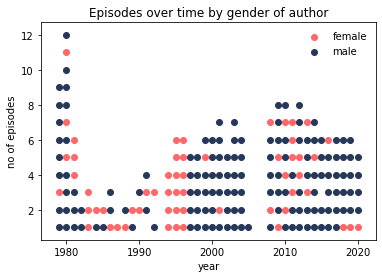

In [32]:
# gender distribution in authors over time

x = meta["year"].loc[meta["author_gender"]=="female"]
y = meta["no_per_year"].loc[meta["author_gender"]=="female"]

plt.scatter(x, y, c='#ff6768', label='female')

x = meta["year"].loc[meta["author_gender"]=="male"]
y = meta["no_per_year"].loc[meta["author_gender"]=="male"]

plt.scatter(x, y, c='#263859', label='male')

plt.title('Episodes over time by gender of author')
plt.xlabel('year')
plt.ylabel('no of episodes')

plt.legend(frameon=False)
plt.savefig('.\\data\\charts\\Episodes over time by gender of author.png')
plt.show()

In [33]:
#number of episodes by top authors and their gender
meta.groupby("author_grouped")[["author_gender", "id"]].agg({"author_gender": "first", "id":"count"}).sort_values(by="id", ascending=False)

,author_gender,id
author_grouped,,
André Marx,male,33
Marco Sonnleitner,male,32
Ben Nevis,male,22
Other,male,18
Brigitte Johanna Henkel-Waidhofer,female,16
M.V. Carey,female,15
William Arden,male,14
Kari Erlhoff,female,13
André Minninger,male,12


### characters

In [34]:
print("average proportion of female side actors")
print(meta["female_side_actors_ratio"].mean())
print("")
print("number of episodes with no female side actor")
print(meta.loc[meta["female_side_actors_ratio"]==0, "id"].count())
print("")
print("episode with highest proportion of female side actors")
print(meta["female_side_actors_ratio"].max(), "%")
print(meta.loc[meta["female_side_actors_ratio"].max(), ["id", "title"]])
print("")
print("episode with highest proportion of female actors")
print(meta["female_actors_ratio"].max(), "%")

average proportion of female side actors
29.316661426282995

number of episodes with no female side actor
11

episode with highest proportion of female side actors
75.0 %
id                            76
title    stimmen aus dem nichts 
Name: 75, dtype: object

episode with highest proportion of female actors
50.0 %


In [35]:
## Look at episodes by female character proportions

#bins
bins = [-1, 20, 40, 60, 80, np.inf]

#create binned variables
meta["female_side_actors_ratio_bins"] = pd.cut(meta["female_side_actors_ratio"], bins, labels=["0-20", "21-40", "41-60", "61-80", "81-100"])
meta["female_actors_ratio_bins"] = pd.cut(meta["female_actors_ratio"], bins, labels=["0-20", "21-40", "41-60", "61-80", "81-100"])

#create pivot tables and combine them
side = pd.DataFrame(meta.groupby("female_side_actors_ratio_bins")["id"].count())
with_main = pd.DataFrame(meta.groupby("female_actors_ratio_bins")["id"].count())
actors_ratio = pd.merge(side, with_main, left_index=True, right_index=True, suffixes=['_side', '_with_main'])
actors_ratio = actors_ratio.reset_index().rename(columns={"female_side_actors_ratio_bins":"Proportion_female_actors",
                                                          "id_side": "side_actors", 
                                                          "id_with_main":"all_actors"})


#save as csv
actors_ratio.to_csv(".\\data\\charts\\female_actors_ratio.csv", index=False)

# calculate number of episodes as %
actors_ratio_perc = actors_ratio.copy()
actors_ratio_perc[["side_actors", "all_actors"]] = round(actors_ratio_perc[["side_actors", "all_actors"]] / len(meta["female_side_actors_ratio"]) *100,0)

#save as csv
actors_ratio_perc.to_csv(".\\data\\charts\\female_actors_ratio_perc.csv", index=False)

#display
actors_ratio

,Proportion_female_actors,side_actors,all_actors
0,0-20,63,112
1,21-40,100,85
2,41-60,34,9
3,61-80,9,0
4,81-100,0,0


### Relationship: author gender and character ratio 

In [72]:
meta.groupby("author_gender")["female_side_actors_ratio"].mean()

author_gender
female    33.084884
male      27.770758
Name: female_side_actors_ratio, dtype: float64

# Explorative Analysis

## Chronology

The number of episodes published each year varies over time. Since the German publisher Kosmos took over the book writing in 2993, there has been more consistency. 

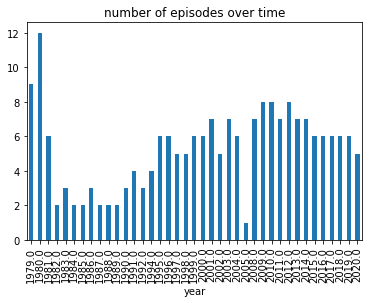

In [36]:
meta.groupby("year")["id"].count().plot(kind='bar', title="number of episodes over time")

### Length

Episodes are getting longer on average over time

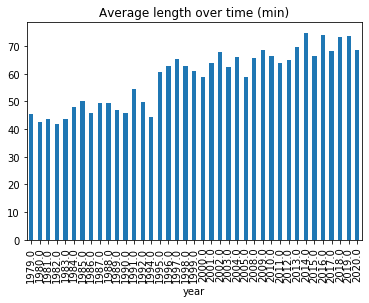

In [37]:
meta.groupby("year")["minutes_mean"].mean().plot(kind='bar', title="Average length over time (min)")

### dotplot

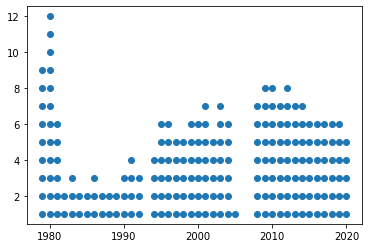

In [38]:
x = meta["year"]
y = meta["no_per_year"]

plt.scatter(x, y)

### Month

October is the most popular release month but mainly because of the first two years when 15 episodes were released in October.

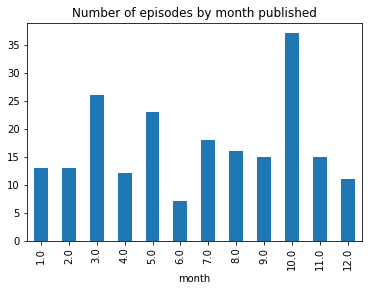

In [39]:
meta.groupby("month")["id"].count().plot(kind='bar', title='Number of episodes by month published')

## Gender

### female writers and character ratio

In [71]:

meta.groupby("author_gender")["female_side_actors_ratio"].mean()

author_gender
female    33.084884
male      27.770758
Name: female_side_actors_ratio, dtype: float64

### female character ratio by publisher

In [40]:
publisher_gender_ratio = meta.groupby(["publisher", "female_side_actors_ratio_bins"], 
                                      as_index=False)["id"].count().pivot("publisher", "female_side_actors_ratio_bins").fillna(0)

publisher_gender_ratio.columns = publisher_gender_ratio.columns.droplevel(0)

# to csv
publisher_gender_ratio.transpose().to_csv(".\\data\\charts\\female_actors_ratio_by_publisher.csv")

publisher_gender_ratio.transpose()


publisher,German,Original
female_side_actors_ratio_bins,,
0-20,38.0,25.0
21-40,73.0,27.0
41-60,31.0,3.0
61-80,9.0,0.0
81-100,0.0,0.0


In [41]:
print(meta.groupby("publisher")["female_side_actors_ratio"].agg(["mean", "max", "min"]))
print(meta.loc[meta["female_side_actors_ratio"]==0].groupby("publisher")["id"].count())

                mean   max  min
publisher                      
German     31.892051  75.0  0.0
Original   22.246047  50.0  0.0
publisher
German      8
Original    3
Name: id, dtype: int64


### female character ratio by year

In [42]:
bins = [1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020]
meta["years_bins"] = pd.cut(meta["year"], bins)

female_actors_years = meta.groupby("years_bins")["female_side_actors_ratio"].mean()


#actors_ratio.to_csv(".\\data\\charts\\female_actors_ratio.csv", index=False)

female_actors_years

years_bins
(1975, 1980]    20.105820
(1980, 1985]    17.820254
(1985, 1990]    30.666972
(1990, 1995]    33.947882
(1995, 2000]    32.834239
(2000, 2005]    38.626021
(2005, 2010]    23.789701
(2010, 2015]    26.211113
(2015, 2020]    35.048319
Name: female_side_actors_ratio, dtype: float64

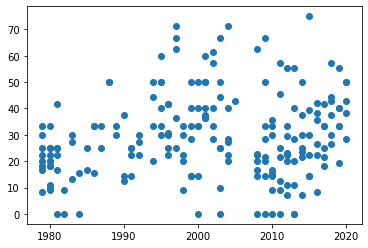

In [43]:
x = meta["year"]
y = meta["female_side_actors_ratio"]

plt.scatter(x, y)

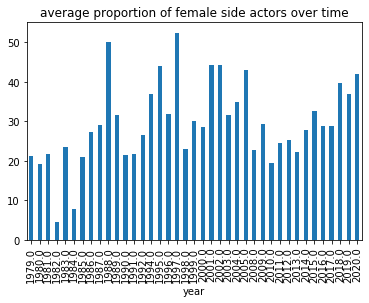

In [44]:
meta.groupby("year")["female_side_actors_ratio"].mean().plot(kind='bar', title="average proportion of female side actors over time")

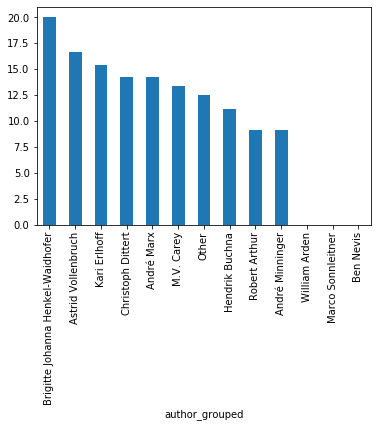

In [45]:
meta.groupby("author_grouped")["female_side_actors_ratio"].min().sort_values(ascending=False).plot(kind='bar')

## titles

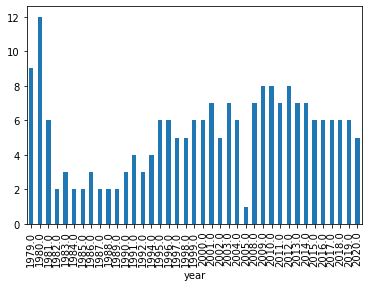

In [46]:
meta.groupby("year")["title_colour"].count().plot(kind='bar')

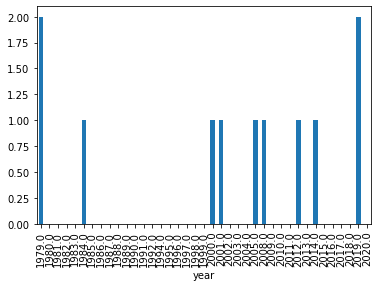

In [47]:
meta.groupby("year")["title_colour"].sum().plot(kind='bar')

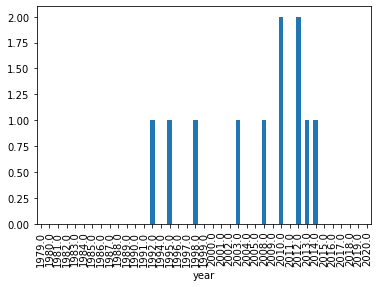

In [48]:
meta.groupby("year")["title_sport"].sum().plot(kind='bar')

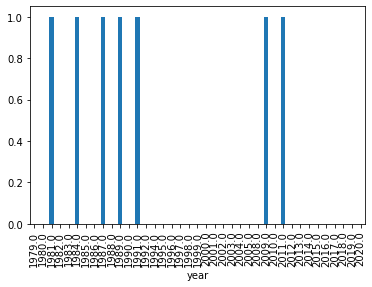

In [49]:
meta.groupby("year")["title_ethnic"].sum().plot(kind='bar')

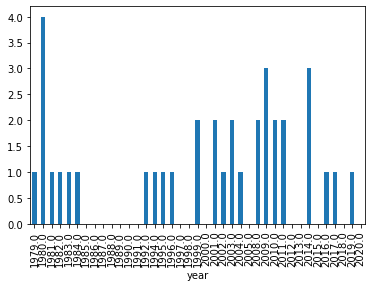

In [50]:
meta.groupby("year")["title_place"].sum().plot(kind='bar')

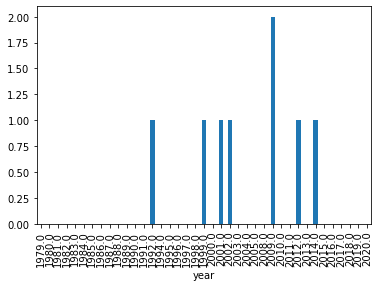

In [51]:
meta.groupby("year")["title_tech"].sum().plot(kind='bar')

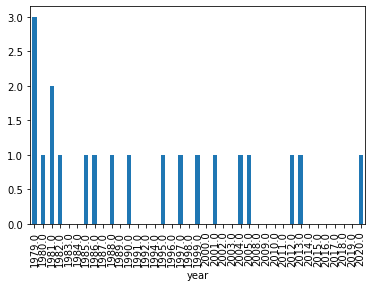

In [52]:
meta.groupby("year")["title_animal"].sum().plot(kind='bar')

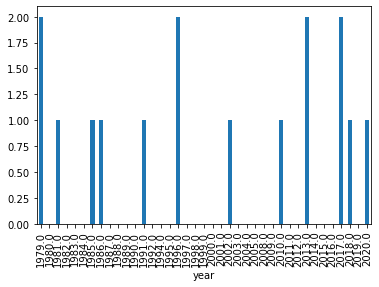

In [53]:
meta.groupby("year")["title_mystery"].sum().plot(kind='bar')

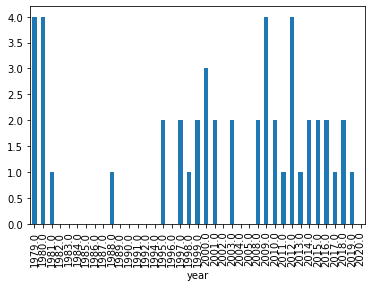

In [54]:
meta.groupby("year")["title_paranormal"].sum().plot(kind='bar')

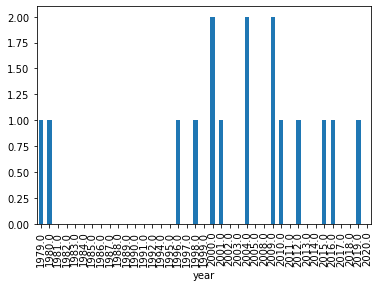

In [55]:
meta.groupby("year")["title_death"].sum().plot(kind='bar')

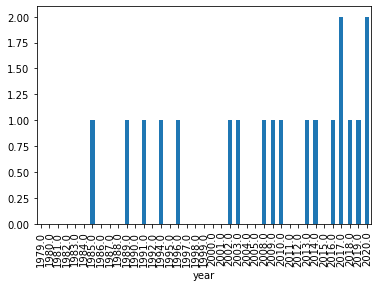

In [56]:
meta.groupby("year")["title_person"].sum().plot(kind='bar')

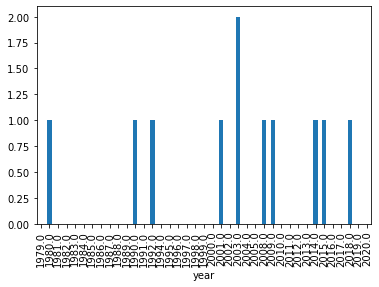

In [57]:
meta.groupby("year")["title_danger"].sum().plot(kind='bar')

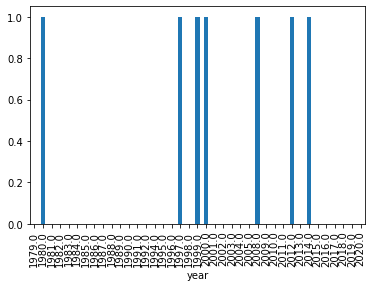

In [58]:
meta.groupby("year")["title_fire"].sum().plot(kind='bar')

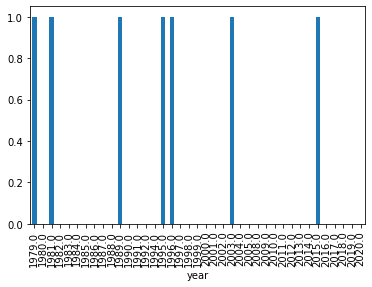

In [59]:
meta.groupby("year")["title_treasure"].sum().plot(kind='bar')

## Rating

In [60]:
rating.columns

Index(['episode', 'rating', 'rating_rank', 'no_votes', 'id', 'source'], dtype='object')

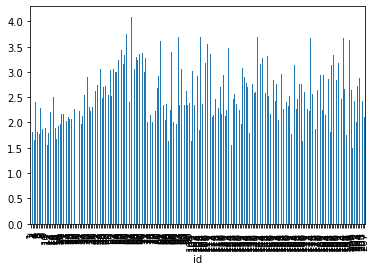

In [61]:
#number of episodes over time
meta.set_index("id")["rating"].plot(kind='bar')

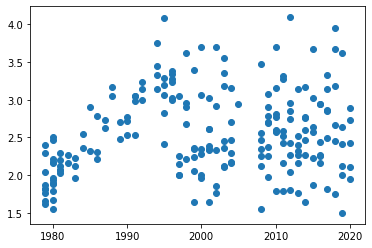

In [62]:
x = meta["year"]
y = meta["rating"]

plt.scatter(x, y)

In [63]:
meta.shape

(207, 85)

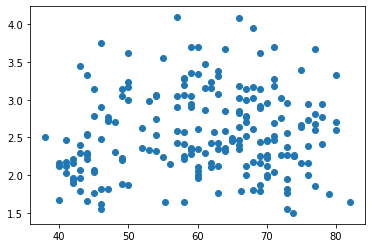

In [64]:
x = meta["minutes_mean"]
y = meta["rating"]

plt.scatter(x, y)

### Author

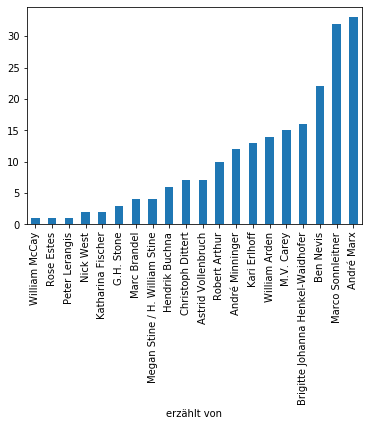

In [65]:
meta.groupby("erzählt von")["rating"].count().sort_values().plot(kind='bar')

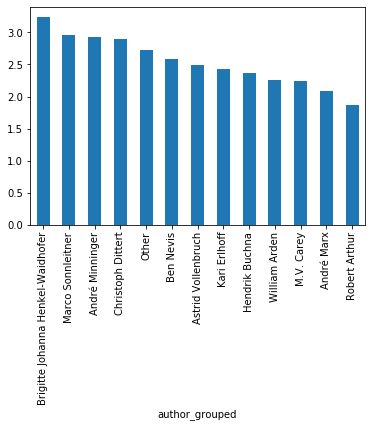

In [66]:
meta.groupby("author_grouped")["rating"].mean().sort_values(ascending=False).plot(kind='bar')

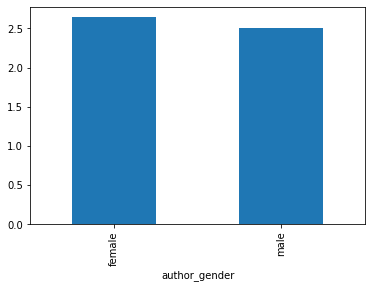

In [67]:
meta.groupby("author_gender")["rating"].mean().plot(kind='bar')

### Actors

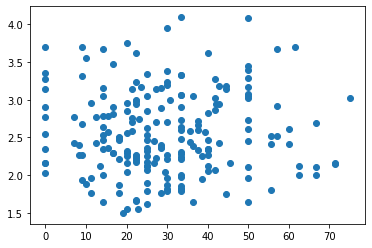

In [68]:
x = meta["female_side_actors_ratio"]
y = meta["rating"]

plt.scatter(x, y)

### Topic

Seems like sport and tech themes have slightly lower ratings

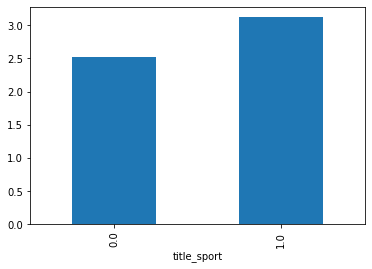

In [69]:
meta.groupby("title_sport")["rating"].mean().plot(kind='bar')

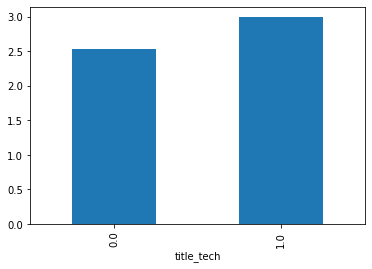

In [70]:
meta.groupby("title_tech")["rating"].mean().plot(kind='bar')